# 인코딩(encoding)과 디코딩(decoding)

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 떄 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>


# 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>


## Fashon MNIST Dataset

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko


[과제] Fashipn MNIST Dataset으로 오토인코더를 활용하여 이미지 생성을 수행하세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성합니다. 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련합니다.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [3]:
(x_train, _),(x_test,_) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

x_train = x_train[..., tf.newaxis] # tf.newaxis로 차원 수 늘리기
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [5]:
# 이미지에 임의의 노이즈 추가
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
# 텐서가 주어지면 값이 clip_value_min 및 clip_value_max로 클리핑 된 텐서와 동일한 유형 및 모양의 텐서를 반환
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

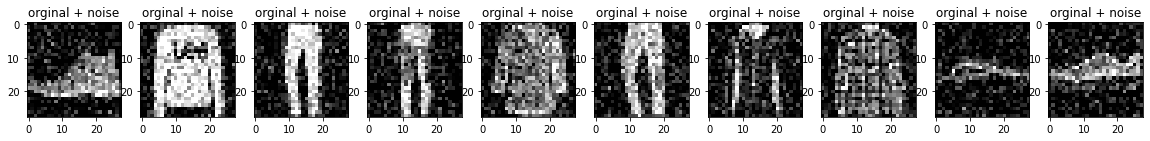

In [7]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  ax = plt.subplot(1,n,i+1)
  plt.title('orginal + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
plt.show()

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([                                        
      layers.Input(shape=(28,28,1)),
      layers.Conv2D(16,(3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8,(3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
    
        
  

In [11]:
autoencoder.compile(optimizer='adam', loss = losses.MeanSquaredError())

In [13]:
autoencoder.fit(x_train_noisy, x_train,
               epochs=10,
               shuffle=True,
               validation_data=(x_test_noisy,x_test))

Epoch 1/10
1875/1875 [==============================] - 15s 3ms/step - loss: 0.0172 - val_loss: 0.0099
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.00

In [14]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [16]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

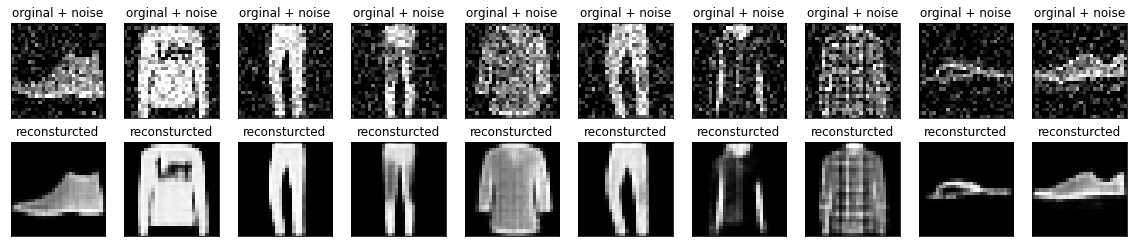

In [18]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  # display original + noise
  ax = plt.subplot(2,n,i+1)
  plt.title('orginal + noise')
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display recontruction
  bx = plt.subplot(2,n,i+n+1)
  plt.title('reconsturcted')
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  bx.get_xaxis().set_visible(False)
  bx.get_yaxis().set_visible(False)
  
plt.show()

## 개요

이 예에서는 [ECG5000 데이터세트](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)에서 이상을 감지하도록 autoencoder를 훈련합니다. 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 [심전도](https://en.wikipedia.org/wiki/Electrocardiography)가 포함되어 있습니다. 단순화 된 버전의 데이터세트를 사용하고, 각 예제는 `0`(비정상 리듬에 해당) 또는 `1`(정상 리듬에 해당)으로 레이블이 지정됩니다. 여러분은 비정상 리듬을 식별하는 데 관심이 있습니다.

참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있습니다. 이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것입니다(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우).

autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? autoencoder는 재구성 오류를 최소화하도록 훈련되었습니다. autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성합니다. 여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것입니다. 그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류합니다.


In [19]:
# Download the dataset

import pandas as pd
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv',header=None)
raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [20]:
df.iloc[:,-1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [21]:
labels = raw_data[:,-1]
data = raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21)

In [24]:
# 데이털르 [0,1]로 정규화
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val-min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [25]:
train_data.shape

TensorShape([3998, 140])

이 데이터 세트에서 1로 레이블된 정상리듬만 사용하여 autoencoder를 훈

In [27]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [28]:
normal_train_data.shape

TensorShape([2359, 140])

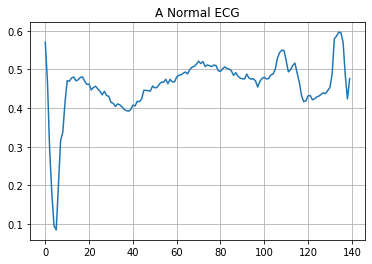

In [29]:
# 정상적인 ECG plot
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

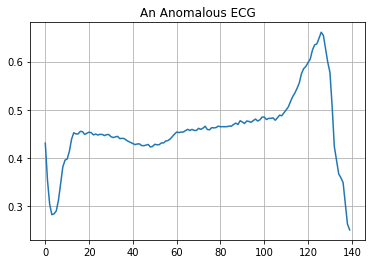

In [30]:
# 비정상적인 ECG plot
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title('An Anomalous ECG')
plt.show()

In [31]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32,activation='relu'),
      layers.Dense(16,activation='relu'),
      layers.Dense(8,activation='relu')                                  
    ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'), 
      layers.Dense(140, activation='sigmoid')                                   
    ])
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded 

autoencoder = AnomalyDetector()

In [34]:
autoencoder.compile(optimizer='adam',loss='mae')

In [36]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                         epochs=20,
                         batch_size=512,
                         validation_data=(test_data,test_data),
                         shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 34ms/step - loss: 0.0616 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0561 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0542 - val_loss: 0.0499
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0508 - val_loss: 0.0479
Epoch 5/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0471 - val_loss: 0.0469
Epoch 6/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0436 - val_loss: 0.0449
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0401 - val_loss: 0.0428
Epoch 8/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0414
Epoch 9/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0341 - val_loss: 0.0404
Epoch 10/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0319 - val_loss: 0.0393
Epoch 11/20
5/5 [=====================

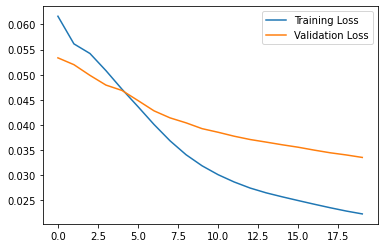

In [37]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

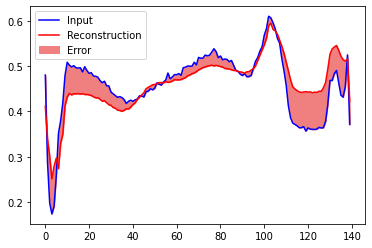

In [39]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0],color='lightcoral')
plt.legend(labels=['Input','Reconstruction','Error'])
plt.show()

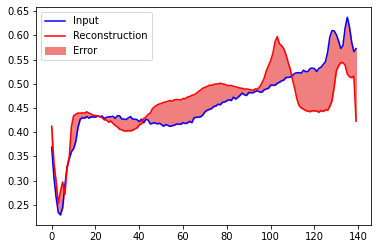

In [41]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0],color='lightcoral')
plt.legend(labels=['Input','Reconstruction','Error'])
plt.show()

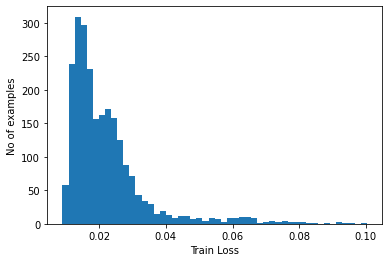

In [42]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss,bins=50)
plt.xlabel('Train Loss')
plt.ylabel('No of examples')
plt.show()

평균보다 표준편차가 높은 임계값을 선택

In [44]:
threshold = np.mean(train_loss) + np.std(train_loss)
print('Threshold:', threshold)

Threshold: 0.0338706


재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분

In [45]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions,data)
  return tf.math.less(loss, threshold)

def print_stats(predictions,labels):
  print('Accuracy = {}'.format(accuracy_score(labels,preds)))
  print('Precision = {}'.format(precision_score(labels,preds)))
  print('Recall ={}'.format(recall_score(labels,preds)))

In [46]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds,test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall =0.9071428571428571


[과제] ECG 이상 감지 프로세스를 설명할 수 있도록 복습을 통한 이해 